### TASK 4: SLEEP STAGING FROM EEG/EMG

In this task we will perform sequence classification. We will categorize temporally coherent and uniformly distributed short sections of a long time-series. In particular, for each 4 seconds of a lengthy EEG/EMG measurement of brain activity recorded during sleep, we will assign one of the 3 classes corresponding to the sleep stage present within the evaluated epoch.

The training targets (sleep stages) take the values from {1: "WAKE phase", 2: "NREM phase", 3: "REM phase"}.

In [110]:
# import libraries
import biosppy
import biosppy.signals.eeg as eeg
import biosppy.signals.emg as emg
import pywt
import statistics
import scipy.stats
import sklearn.preprocessing
import pandas as pd
import numpy as np
import os, glob
import tensorflow as tf
from matplotlib import pyplot as plt
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.metrics import plot_confusion_matrix
from sklearn import preprocessing
from sklearn.preprocessing import normalize

In [2]:
# load the data
train_eeg1_df = pd.read_csv('./data/train_eeg1.csv')
train_eeg2_df = pd.read_csv('./data/train_eeg2.csv')
train_emg_df = pd.read_csv('./data/train_emg.csv')

test_eeg1_df = pd.read_csv('./data/test_eeg1.csv')
test_eeg2_df = pd.read_csv('./data/test_eeg2.csv')
test_emg_df = pd.read_csv('./data/test_emg.csv')

train_labels_df = pd.read_csv('./data/train_labels.csv')

In [5]:
train_eeg1_df

,Id,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x503,x504,x505,x506,x507,x508,x509,x510,x511,x512
0,0,0.000400,0.000470,0.000067,-0.000160,-0.000003,0.000310,0.000360,0.000190,-0.000072,...,-0.000086,0.000033,-0.000046,-0.000270,-0.000390,-0.000340,-0.000320,-0.00021,0.000042,0.000053
1,1,0.000067,0.000095,0.000270,0.000280,0.000250,0.000120,0.000094,-0.000340,-0.000960,...,0.000046,0.000300,0.000630,0.000710,0.000520,0.000410,0.000660,0.00088,0.000770,0.000410
2,2,0.000160,-0.000210,-0.000840,-0.001200,-0.001200,-0.001400,-0.001400,-0.000910,-0.000600,...,-0.000680,-0.000880,-0.001000,-0.000770,-0.000680,-0.000730,-0.000730,-0.00062,-0.000550,-0.000540
3,3,-0.000140,0.000260,0.000390,0.000430,0.000280,0.000230,0.000390,0.000220,0.000150,...,0.000720,0.000760,0.000380,0.000052,-0.000260,-0.000580,-0.000750,-0.00110,-0.001200,-0.001200
4,4,-0.001100,-0.000790,-0.000081,0.000140,0.000200,-0.000140,-0.000430,-0.000530,-0.000580,...,0.000290,0.000600,0.000670,0.000190,-0.000055,-0.000160,-0.000230,-0.00023,-0.000330,-0.000810
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64795,64795,-0.000650,-0.000300,-0.000019,0.000390,0.000260,0.000083,0.000180,0.000480,0.000430,...,0.000310,0.000660,0.000310,0.000320,0.000038,-0.000099,-0.000130,-0.00051,-0.000530,-0.000370
64796,64796,-0.000350,0.000026,0.000044,-0.000026,-0.000230,0.000080,0.000095,0.000067,0.000200,...,-0.000330,-0.000460,-0.000660,-0.000630,-0.000710,-0.000580,-0.000720,-0.00058,-0.000530,-0.000320
64797,64797,-0.000210,-0.000070,-0.000030,0.000100,0.000180,-0.000081,-0.000350,-0.000520,-0.000400,...,0.000074,-0.000120,0.000010,0.000130,-0.000150,-0.000230,-0.000019,-0.00018,0.000014,0.000260
64798,64798,0.000080,0.000280,0.000075,0.000330,0.000310,-0.000012,-0.000170,-0.000270,-0.000230,...,-0.000610,-0.000420,-0.000310,-0.000340,-0.000420,-0.000060,0.000082,0.00026,0.000130,0.000170


### Preprocessing

In [31]:
# copy data
train_eeg1 = train_eeg1_df.copy()
train_eeg2 = train_eeg2_df.copy()
train_emg = train_emg_df.copy()

# merge labels to dataframe (for plotting)
train_eeg1['y'] = train_labels_df['y']
train_eeg2['y'] = train_labels_df['y']
train_emg['y'] = train_labels_df['y']

# drop 'id' column
train_eeg1 = train_eeg1.drop(['Id'], axis=1)
train_eeg2 = train_eeg2.drop(['Id'], axis=1)
train_emg = train_emg.drop(['Id'], axis=1)

# assign label vector
y_train = train_labels_df['y']

# make arrays out of the dataframes
#X_training = np.array(train_features)
#X_testing = np.array(test_features)
#y_training = np.array(train_labels)

#print(train_eeg1.shape, train_eeg2.shape, train_emg.shape)
print(y_train.shape[0], 'samples')

64800 samples


In [32]:
# check the distribution of each class
label_names = ['awake', 'non-rem', 'rem']
labels, counts = np.unique(y_train, return_counts=True)
for i in range(len(labels)):
    print('class {}: {} - {}'.format(labels[i], counts[i], label_names[i]))

class 1: 34114 - awake
class 2: 27133 - non-rem
class 3: 3553 - rem


In [33]:
# plot some examples 
def plot_examples(cl, df, all_classes=False):
    rand = np.random.randint(150, size=5)
    fig, ax = plt.subplots(len(rand), figsize=(15,12), constrained_layout=True)
    if all_classes == True:
        for i in range(len(rand)):
            for lab in labels:
                df.loc[df['y'] == lab].iloc[rand[i], :-1].plot(ax=ax[i], label='class {}'.format(lab))
            ax[i].set(title='Sample {}'.format(rand[i]))
            ax[i].legend(loc='upper left')
        return
    else:
        for i in range(len(rand)):
            df.loc[df['y'] == cl].iloc[rand[i], :-1].plot(ax=ax[i], label='class {}'.format(cl))
            ax[i].set(title='Sample {}'.format(rand[i]))
            ax[i].legend(loc='upper left')
        return

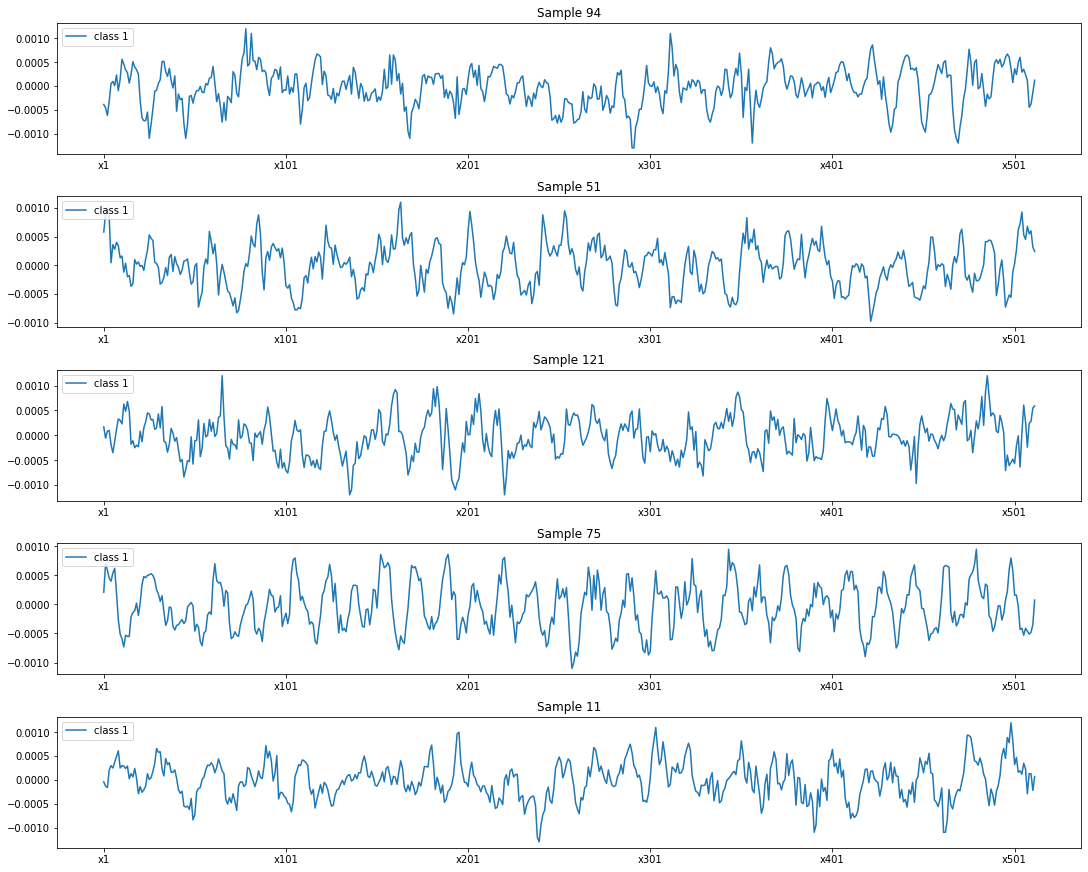

In [34]:
plot_examples(1, train_eeg2, False) # choose class or choose to show all classes (chosen class is ignored) 

In [35]:
# drop label from the training dataframes
train_eeg1 = train_eeg1.drop(columns='y')
train_eeg2 = train_eeg2.drop(columns='y')
train_emg = train_emg.drop(columns='y')

# convert to array
train_eeg1 = train_eeg1.to_numpy()
train_eeg2 = train_eeg2.to_numpy()
train_emg = train_emg.to_numpy()

test_eeg1 = test_eeg1.to_numpy()
test_eeg2 = test_eeg2.to_numpy()
test_emg = test_emg.to_numpy()

# normalize 
train_eeg1 = normalize(train_eeg1)
train_eeg2 = normalize(train_eeg2)
train_emg = normalize(train_emg)

test_eeg1 = normalize(test_eeg1)
test_eeg2 = normalize(test_eeg2)
test_emg = normalize(test_emg)

print(train_eeg1.shape, train_eeg2.shape, train_emg.shape)
print(test_eeg1.shape, test_eeg2.shape, test_emg.shape)
print(y_train.shape)

(64800, 512) (64800, 512) (64800, 512)
(64800,)


### Feature Extraction

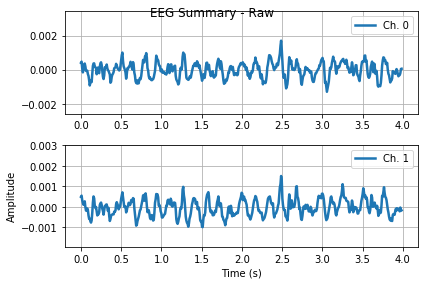

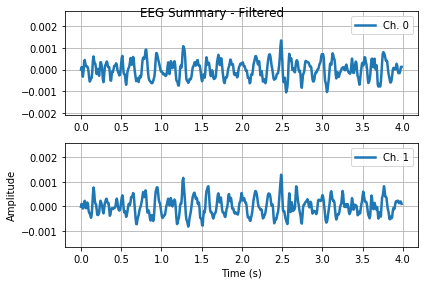

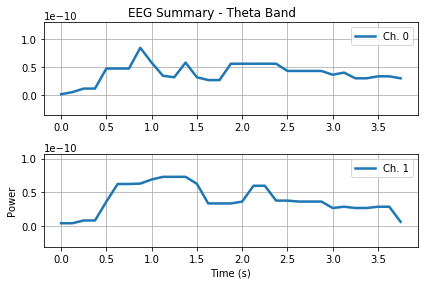

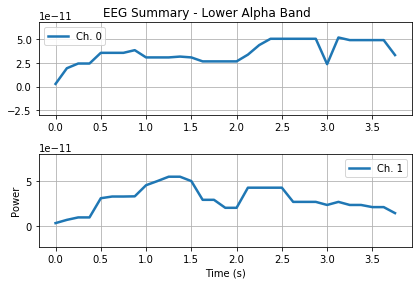

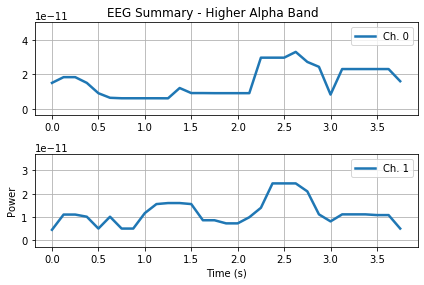

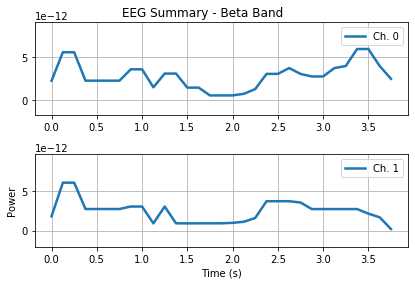

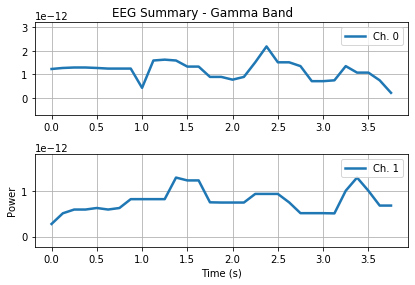

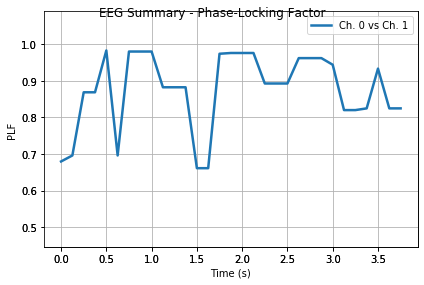

In [57]:
signal_array = np.column_stack((train_eeg1[0], train_eeg2[0]))
ts, filtered, features_ts, theta, alpha_low, alpha_high, beta, gamma, plf_pairs, plf = biosppy.signals.eeg.eeg(signal_array, sampling_rate=128, show=True)

In [14]:
# lowpass- / highpassfilter functions for emg analysis
from scipy.signal import butter, lfilter, freqz

def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = lfilter(b, a, data)
    return y

In [15]:
# extract EEG and EMG features

def extract_features(eeg1_data, eeg2_data, emg_data):
    
    # --------------------------------------------------
    # extract EEG signal features with biosppy
    # --------------------------------------------------
    
    ts_list = []
    filtered_list = []
    features_ts_list = []
    theta_list = []
    alpha_low_list = []
    alpha_high_list = []
    beta_list = []
    gamma_list = []
    plf_pairs_list = []
    plf_list = []

    for sample1, sample2 in zip(eeg1_data, eeg2_data):
        joint = np.column_stack((sample1, sample2))
        ts, filtered, features_ts, theta, alpha_low, alpha_high, beta, gamma, plf_pairs, plf = eeg.eeg(joint, sampling_rate=128, show=False)
        ts_list.append(ts)
        filtered_list.append(filtered)
        features_ts_list.append(features_ts)
        theta_list.append(theta)
        alpha_low_list.append(alpha_low)
        alpha_high_list.append(alpha_high)
        beta_list.append(beta)
        gamma_list.append(gamma)
        plf_pairs_list.append(plf_pairs)
        plf_list.append(plf)
    
    # --------------------------------------------------
    # extract EEG stats from features
    # --------------------------------------------------
    
    feat_list = [theta_list, alpha_low_list, alpha_high_list, beta_list, gamma_list, plf_list]
    theta_mean_list = []
    theta_std_list = []
    theta_var_list = []
    theta_range_list = []
    theta_energy_list = []
    alpha_low_mean_list = []
    alpha_low_std_list = []
    alpha_low_var_list = []
    alpha_low_range_list = []
    alpha_low_energy_list = []
    alpha_high_mean_list = []
    alpha_high_std_list = []
    alpha_high_var_list = []
    alpha_high_range_list = []
    alpha_high_energy_list = []
    beta_mean_list = []
    beta_std_list = []
    beta_var_list = []
    beta_range_list = []
    beta_energy_list = []
    gamma_mean_list = []
    gamma_std_list = []
    gamma_var_list = []
    gamma_range_list = []
    gamma_energy_list = []
    plf_mean_list = []
    plf_std_list = []
    plf_var_list = []
    plf_range_list = []
    plf_energy_list = []

    total_energies_list=[]
    for i in range(len(theta_list)):
        total_energies_list.append(np.sum(theta_list[i]** 2)+np.sum(alpha_low_list[i]** 2)+
                                 np.sum(alpha_high_list[i]** 2)+np.sum(alpha_high_list[i]** 2)+
                                 np.sum(gamma_list[i]** 2))

    for i in range(len(feat_list)):
        for j in feat_list[i]:
            if i == 0:
                theta_mean_list.append(np.mean(j))
                theta_std_list.append(np.std(j))
                theta_var_list.append(np.var(j))
                theta_range_list.append(np.ptp(j))
                theta_energy_list.append(np.sum(j** 2))
            if i == 1:
                alpha_low_mean_list.append(np.mean(j))
                alpha_low_std_list.append(np.std(j))
                alpha_low_var_list.append(np.var(j))
                alpha_low_range_list.append(np.ptp(j))
                alpha_low_energy_list.append(np.sum(j** 2))
            if i == 2:
                alpha_high_mean_list.append(np.mean(j))
                alpha_high_std_list.append(np.std(j))
                alpha_high_var_list.append(np.var(j))
                alpha_high_range_list.append(np.ptp(j))
                alpha_high_energy_list.append(np.sum(j** 2))
            if i == 3:
                beta_mean_list.append(np.mean(j))
                beta_std_list.append(np.std(j))
                beta_var_list.append(np.var(j))
                beta_range_list.append(np.ptp(j))
                beta_energy_list.append(np.sum(j** 2))
            if i == 4:
                gamma_mean_list.append(np.mean(j))
                gamma_std_list.append(np.std(j))
                gamma_var_list.append(np.var(j))
                gamma_range_list.append(np.ptp(j))
                gamma_energy_list.append(np.sum(j** 2))
            elif i == 5:
                plf_mean_list.append(np.mean(j))
                plf_std_list.append(np.std(j))
                plf_var_list.append(np.var(j))
                plf_range_list.append(np.ptp(j))
                plf_energy_list.append(np.sum(j** 2))
                
    # ratios std
    theta_energy_list_std = np.divide(theta_std_list, total_energies_list)
    alpha_low_energy_list_std = np.divide(alpha_low_std_list, total_energies_list)
    alpha_high_energy_list_std = np.divide(alpha_high_std_list, total_energies_list)
    beta_energy_list_std = np.divide(beta_std_list, total_energies_list)
    gamma_energy_list_std = np.divide(gamma_std_list, total_energies_list)
    plf_energy_list_std = np.divide(plf_std_list, total_energies_list)
    # ratios mean
    theta_energy_list_mean = np.divide(theta_mean_list, total_energies_list)
    alpha_low_energy_list_mean = np.divide(alpha_low_mean_list, total_energies_list)
    alpha_high_energy_list_mean = np.divide(alpha_high_mean_list, total_energies_list)
    beta_energy_list_mean = np.divide(beta_mean_list, total_energies_list)
    gamma_energy_list_mean = np.divide(gamma_mean_list, total_energies_list)
    plf_energy_list_mean = np.divide(plf_mean_list, total_energies_list)
    
    
    # --------------------------------------------------
    # extract EMG signal features
    # --------------------------------------------------
    
    fs = 128
    cutoff_lp = 5
    order_lp = 6
    cutoff_hp = 60
    order_hp = 6

    max_peak_lp_list = []
    max_peak_hp_list = []
    min_peak_lp_list = []
    min_peak_hp_list = []
    number_peaks_lp_list = []
    number_peaks_hp_list = []
    mean_lp_list = []
    mean_hp_list = []
    std_lp_list = []
    std_hp_list = []

    for i in emg_data:
        y1 = butter_lowpass_filter(i, cutoff_lp, fs, order_lp)
        y2 = butter_highpass_filter(i, cutoff_hp, fs, order_hp)
        y2 = abs(y2)
        max_peak_lp = np.where(y1==max(y1))
        max_peak_hp = np.where(y2==max(y2))
        min_peak_lp = np.where(y1==min(y1))
        min_peak_hp = np.where(y2==min(y2))
        peaks_lp = scipy.signal.find_peaks(y1)
        peaks_hp = scipy.signal.find_peaks(y2)
        mean_lp = np.mean(y1)
        mean_hp = np.mean(y2)
        std_lp = np.std(y1)
        std_hp = np.std(y2)
        number_peaks_lp = len(peaks_lp[0])
        number_peaks_hp = len(peaks_hp[0])
        max_peak_lp_list.append(max_peak_lp[0][0])
        max_peak_hp_list.append(max_peak_hp[0][0])
        min_peak_lp_list.append(min_peak_lp[0][0])
        min_peak_hp_list.append(min_peak_hp[0][0])
        number_peaks_lp_list.append(number_peaks_lp)
        number_peaks_hp_list.append(number_peaks_hp)
        mean_lp_list.append(mean_lp)
        mean_hp_list.append(mean_hp)
        std_lp_list.append(std_lp)
        std_hp_list.append(std_hp)
    
    
    # --------------------------------------------------
    # merge all features to a dataframe
    # --------------------------------------------------
    
    theta_mean_arr = np.array(theta_mean_list).reshape(-1,1)
    theta_std_arr = np.array(theta_std_list).reshape(-1,1)
    theta_var_arr = np.array(theta_var_list).reshape(-1,1)
    theta_range_arr = np.array(theta_range_list).reshape(-1,1)
    theta_energy_arr = np.array(theta_energy_list).reshape(-1,1)
    alpha_low_mean_arr = np.array(alpha_low_mean_list).reshape(-1,1)
    alpha_low_std_arr = np.array(alpha_low_std_list).reshape(-1,1)
    alpha_low_var_arr = np.array(alpha_low_var_list).reshape(-1,1)
    alpha_low_range_arr = np.array(alpha_low_range_list).reshape(-1,1)
    alpha_low_energy_arr = np.array(alpha_low_energy_list).reshape(-1,1)
    alpha_high_mean_arr = np.array(alpha_high_mean_list).reshape(-1,1)
    alpha_high_std_arr = np.array(alpha_high_std_list).reshape(-1,1)
    alpha_high_var_arr = np.array(alpha_high_var_list).reshape(-1,1)
    alpha_high_range_arr = np.array(alpha_high_range_list).reshape(-1,1)
    alpha_high_energy_arr = np.array(alpha_high_energy_list).reshape(-1,1)
    beta_mean_arr = np.array(beta_mean_list).reshape(-1,1)
    beta_std_arr = np.array(beta_std_list).reshape(-1,1)
    beta_var_arr = np.array(beta_var_list).reshape(-1,1)
    beta_range_arr = np.array(beta_range_list).reshape(-1,1)
    beta_energy_arr = np.array(beta_energy_list).reshape(-1,1)
    gamma_mean_arr = np.array(gamma_mean_list).reshape(-1,1)
    gamma_std_arr = np.array(gamma_std_list).reshape(-1,1)
    gamma_var_arr = np.array(gamma_var_list).reshape(-1,1)
    gamma_range_arr = np.array(gamma_range_list).reshape(-1,1)
    gamma_energy_arr = np.array(gamma_energy_list).reshape(-1,1)
    plf_mean_arr = np.array(plf_mean_list).reshape(-1,1)
    plf_std_arr = np.array(plf_std_list).reshape(-1,1)
    plf_var_arr = np.array(plf_var_list).reshape(-1,1)
    plf_range_arr = np.array(plf_range_list ).reshape(-1,1)
    plf_energy_arr = np.array(plf_energy_list).reshape(-1,1)
    theta_energy_arr_std = np.array(theta_energy_list_std).reshape(-1,1)
    alpha_low_energy_arr_std = np.array(alpha_low_energy_list_std).reshape(-1,1)
    alpha_high_energy_arr_std = np.array(alpha_high_energy_list_std).reshape(-1,1)
    beta_energy_arr_std = np.array(beta_energy_list_std).reshape(-1,1)
    gamma_energy_arr_std = np.array(gamma_energy_list_std).reshape(-1,1)
    plf_energy_arr_std = np.array(plf_energy_list_std).reshape(-1,1)
    theta_energy_arr_mean = np.array(theta_energy_list_mean).reshape(-1,1)
    alpha_low_energy_arr_mean = np.array(alpha_low_energy_list_mean).reshape(-1,1)
    alpha_high_energy_arr_mean = np.array(alpha_high_energy_list_mean).reshape(-1,1)
    beta_energy_arr_mean = np.array(beta_energy_list_mean).reshape(-1,1)
    gamma_energy_arr_mean = np.array(gamma_energy_list_mean).reshape(-1,1)
    plf_energy_arr_mean = np.array(plf_energy_list_mean).reshape(-1,1)
    max_peak_lp_arr = np.array(max_peak_lp_list).reshape(-1,1)
    max_peak_hp_arr = np.array(max_peak_hp_list).reshape(-1,1)
    min_peak_lp_arr = np.array(min_peak_lp_list).reshape(-1,1)
    min_peak_hp_arr = np.array(min_peak_hp_list).reshape(-1,1)
    number_peaks_lp_arr = np.array(number_peaks_lp_list).reshape(-1,1)
    number_peaks_hp_arr = np.array(number_peaks_hp_list).reshape(-1,1)
    mean_lp_arr = np.array(mean_lp_list).reshape(-1,1)
    mean_hp_arr = np.array(mean_hp_list).reshape(-1,1)
    std_lp_arr = np.array(std_lp_list).reshape(-1,1)
    std_hp_arr = np.array(std_hp_list).reshape(-1,1)

    dataframe = np.concatenate((theta_mean_arr, 
        theta_std_arr,
        theta_var_arr, 
        theta_range_arr, 
        theta_energy_arr, 
        alpha_low_mean_arr,
        alpha_low_std_arr, 
        alpha_low_var_arr, 
        alpha_low_range_arr, 
        alpha_low_energy_arr, 
        alpha_high_mean_arr, 
        alpha_high_std_arr, 
        alpha_high_var_arr, 
        alpha_high_range_arr, 
        alpha_high_energy_arr, 
        beta_mean_arr, 
        beta_std_arr, 
        beta_var_arr, 
        beta_range_arr, 
        beta_energy_arr, 
        gamma_mean_arr, 
        gamma_std_arr, 
        gamma_var_arr, 
        gamma_range_arr, 
        gamma_energy_arr, 
        plf_mean_arr, 
        plf_std_arr, 
        plf_var_arr, 
        plf_range_arr, 
        plf_energy_arr, 
        theta_energy_arr_std, 
        alpha_low_energy_arr_std, 
        alpha_high_energy_arr_std,
        beta_energy_arr_std, 
        gamma_energy_arr_std, 
        plf_energy_arr_std, 
        theta_energy_arr_mean, 
        alpha_low_energy_arr_mean, 
        alpha_high_energy_arr_mean,
        beta_energy_arr_mean,
        gamma_energy_arr_mean,
        plf_energy_arr_mean,
        max_peak_lp_arr,
        max_peak_hp_arr,
        min_peak_lp_arr,
        min_peak_hp_arr,
        number_peaks_lp_arr,
        number_peaks_hp_arr,
        mean_lp_arr,
        mean_hp_arr,
        std_lp_arr,
        std_hp_arr), axis=1)       
    
    return dataframe

In [16]:
# function calls
X_train = extract_features(train_eeg1, train_eeg2, train_emg)
X_test = extract_features(test_eeg1, test_eeg2, test_emg)
print(X_train.shape, X_test.shape)
print(y_train.shape)

(64800, 52) (43200, 52)


### Feature Selection

In [96]:
# feature selection
def select_features(X, y, X_t, n_features): # use 'all' to consider all features
    # configure to select a subset of features
    fs = SelectKBest(score_func=f_regression, k=n_features)
    # learn relationship from training data
    fs.fit(X, y)
    # transform train input data
    X_fs = fs.transform(X)
    # transform test input data
    X_fs_t = fs.transform(X_t)
    return X_fs, X_fs_t, fs

In [97]:
feat_num = 29
# Function call
X_train_fs, X_test_fs, fs = select_features(X_train, y_train, X_test, feat_num)
# what are scores for the features
for i in range(10):
    print('Feature %d: %f' % (i, fs.scores_[i]))
print('')
print(X_train_fs.shape, X_test_fs.shape)

Feature 0: 2313.722496
Feature 1: 855.348264
Feature 2: 1031.225274
Feature 3: 912.442367
Feature 4: 5009.680889
Feature 5: 24.486981
Feature 6: 83.535659
Feature 7: 42.619963
Feature 8: 15.562658
Feature 9: 27.010672

(64800, 29) (43200, 29)


### Training preparation

In [98]:
from sklearn.preprocessing import StandardScaler

In [99]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_fs, y_train)
X_test_scaled = scaler.transform(X_test_fs)

In [100]:
from sklearn import svm
from sklearn.model_selection import cross_val_score

In [101]:
labels, counts = np.unique(y_train, return_counts=True)
for i in range(len(labels)):
    print('class {}: {}'.format(labels[i], counts[i]))
print('')
print('total: {}'.format(y_train.shape[0]))

class 1: 34114
class 2: 27133
class 3: 3553

total: 64800


In [102]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_1 = (1 / 34114)*(64800)/3.0 
weight_for_2 = (1 / 27133)*(64800)/3.0
weight_for_3 = (1 / 3553)*(64800)/3.0

weights = {1: weight_for_1, 2: weight_for_2, 3: weight_for_3}

print('Weight for class 1: {:.2f}'.format(weight_for_1))
print('Weight for class 2: {:.2f}'.format(weight_for_2))
print('Weight for class 3: {:.2f}'.format(weight_for_3))

Weight for class 1: 0.63
Weight for class 2: 0.80
Weight for class 3: 6.08


### Training

In [104]:
seed = 77
estimator = svm.SVC(class_weight=weights,
               random_state=seed,
               kernel='rbf',
               tol=0.001,
               gamma='scale',
               degree=3,
               decision_function_shape='ovo',
               C=0.5)

In [105]:
cross_validation = cross_val_score(estimator, X_train_scaled, y_train, cv=5, n_jobs=-1, scoring='balanced_accuracy')

In [106]:
print("bmac: %0.4f (+/- %0.4f)" % (cross_validation.mean(), cross_validation.std() * 2))

bmac: 0.9301 (+/- 0.0570)


In [107]:
estimator.fit(X_train_scaled, y_train)

SVC(C=0.5,
    class_weight={1: 0.6331711320865333, 2: 0.796078575903881,
                  3: 6.079369546861806},
    decision_function_shape='ovo', random_state=77)

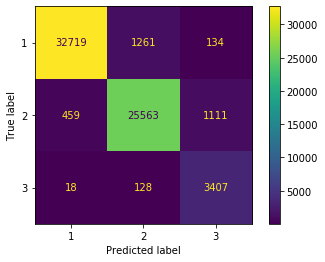

In [111]:
plot_confusion_matrix(estimator, X_train_scaled, y_train)

### Predicting on test set

In [108]:
svc_prediction = estimator.predict(X_test_scaled)

In [109]:
ID = np.array(range(len(X_test_scaled)))
df = pd.DataFrame({'Id': ID,
                    'y': svc_prediction})
name = '03svc_fs29.csv'
path = os.path.join('.', name)
df.to_csv(path, index=False)

### Result

| BMAC scores | |
:- | :-
hard baseline | 0.948
public test set | 0.9140
private test set | 0.9307